In [299]:
#calcular parâmetros das galáxias
#EM CONSTRUÇÃO!
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph
import scipy.ndimage as ndi

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

Filename: /run/media/JackS/windocs/SDSS/frame-g-C0840+1044.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   
Original
Nível de fundo = 0.002365
Ruído de fundo = 0.014674
Subtraido
Nível de fundo = 0.000000
Ruído de fundo = 0.014674


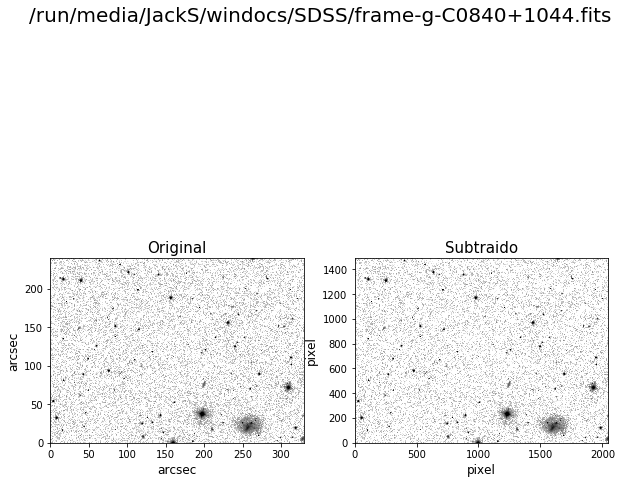

In [311]:
#Full image + backgoround + noise
from astropy.io import fits
from copy import deepcopy

#IMAGEM
filename = 'C0840+1044'

image_full='/run/media/JackS/windocs/SDSS/frame-g-'+filename+'.fits'
#image_full = get_pkg_data_filename(image_full) #Info WCS
fits.info(image_full)

FITSe = fits.open(image_full)
FITSe = FITSe[0].data
FITS = deepcopy(FITSe)
x , y = FITSe.shape[1] , FITSe.shape[0] #limite dos eixos usado para formatar os axis image. (tbm pode ser usado FITSe[0].header[3] e 4)
#------------------------------
weight = '/run/media/JackS/windocs/SDSS/'+filename+'_SDSS_map_rms.fits'   #Importe o mapa de peso. Estatística de Poisson.
MAP_RMS = fits.open(weight)
map_rms = MAP_RMS[0].data
#------------------------------
MASK = 'mask_px.fits'        #Importe a máscara.
Mask = fits.open(MASK)
Mask = Mask[0].data
#------------------------------
SEGMAP = '/run/media/JackS/windocs/SDSS/'+filename+'_SDSS_segmentation.fits'  #Importe o mapa de segmentação. OPICIONAL se for usar sextractor
Segmap = fits.open(SEGMAP)
Segmap = Segmap[0].data
#------------------------------
from astropy.stats import sigma_clipped_stats  #Estatistica sigma clipped
mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Original')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

FITSe -= median  #subtraindo o background

mean , median , std = sigma_clipped_stats( FITSe, sigma = 3. )
print('Subtraido')
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

#--------------------------
#Plot das imagens
fig ,(ax1 , ax2) = plt.subplots(1,2,figsize=(10, 10))
fig.suptitle(image_full, fontsize=20)
#import matplotlib.ticker as ticker
#ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_xlabel('arcsec',fontsize=12)
ax1.set_ylabel('arcsec',fontsize=12)
ax1.set_title('Original',fontsize=15)
ax1.imshow(FITS, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0),extent=[0,x*0.396,0,y*0.396])
ax1.set_aspect(1)

ax2.set_xlabel('pixel',fontsize=12)
ax2.set_ylabel('pixel',fontsize=12)
ax2.set_title('Subtraido',fontsize=15)
ax2.imshow(FITSe, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))


In [312]:
#FITS = FITSe
GHII = FITS[0:200,1194:1418] # obs:Já está em FITS[0].data
image_star = FITS[278:378,952:1052]
#image_star = FITS[584:804,0:220]
map_rms = map_rms[0:200,1194:1418]
Mask = Mask[0:200,1194:1418]
Segmap = Segmap[0:224,1194:1418]

Nível de fundo = 0.006165
Ruído de fundo = 0.015481
[[ 3.8146973e-05 -3.6506653e-03 -1.1039734e-02 ... -1.8371582e-02
  -1.4678955e-02  8.3923340e-05]
 [-2.5817871e-02  3.7384033e-03 -1.4739990e-02 ...  8.3923340e-05
  -2.9449463e-02 -2.2064209e-02]
 [-1.1039734e-02  1.4831543e-02 -3.6544800e-03 ...  3.7841797e-03
   1.1169434e-02  1.8554688e-02]
 ...
 [ 4.4311523e-02  7.3547363e-03  2.5817871e-02 ...  1.5258789e-05
   3.7078857e-03  1.5258789e-05]
 [ 2.5817871e-02  1.8432617e-02  2.2125244e-02 ...  3.7078857e-03
  -2.2125244e-02 -1.8447876e-02]
 [ 1.8432617e-02  4.0588379e-02  3.3203125e-02 ...  7.4005127e-03
   7.4005127e-03 -7.3699951e-03]]
200


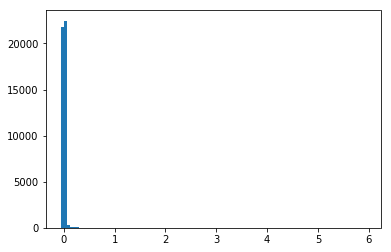

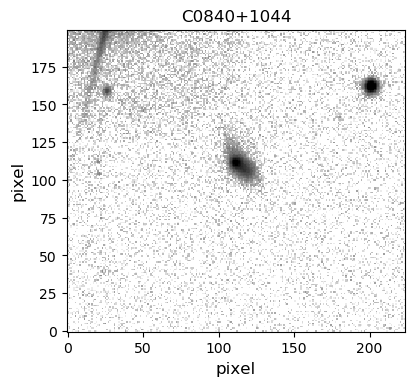

In [313]:
#Galáxia
%matplotlib inline
image_data = GHII
NBINS = 100
histogram = plt.hist(image_data.flatten(), NBINS) #histograma usado para saber os limites de pixel

mean , median , std = sigma_clipped_stats( image_data, sigma = 3. )
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))
image_data-=median

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)

print(image_data)
print(len(image_data))
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
#plt.savefig(GHII+'_ori.png')

#image_data.writeto( 'new_'+filename+'.fits',overwrite='true',checksum='true' ) #Cria um fits novo 

Nível de fundo = 0.002403
Ruído de fundo = 0.014345
[[ 4.1961670e-05  4.1961670e-05 -3.6602020e-03 ...  2.9518127e-02
   3.6773682e-03  3.3180237e-02]
 [-7.3623657e-03  1.4869690e-02  3.7460327e-03 ... -1.1070251e-02
   4.4288635e-02  1.4747620e-02]
 [ 7.4539185e-03  1.8562317e-02  4.1961670e-05 ... -1.8455505e-02
  -7.6293945e-06  7.3623657e-03]
 ...
 [-1.4793396e-02 -7.3852539e-03  3.3363342e-02 ...  1.1024475e-02
  -3.7250519e-03  2.2102356e-02]
 [-1.8486023e-02  1.5258789e-05 -2.2209167e-02 ... -7.4081421e-03
  -2.2178650e-02 -2.2178650e-02]
 [-1.4793396e-02 -3.6869049e-03 -3.3317566e-02 ... -7.4157715e-03
   3.6544800e-03 -3.3256531e-02]]
100


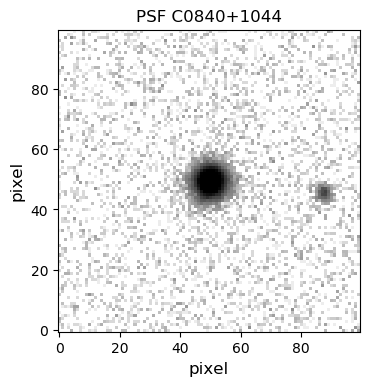

In [314]:
#Estrela PSF
psf = image_star

median = np.median(psf)
mean , median , std = sigma_clipped_stats( psf , sigma = 3. )
print('Nível de fundo = %f'%(median))
print('Ruído de fundo = %f'%(std))

psf -= median
fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title('PSF '+filename)
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(psf, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1.0))
print(psf) #Matriz estrela
print(len(psf))

[[0.01422272 0.01415931 0.01409953 ... 0.01385189 0.01385029 0.013849  ]
 [0.014224   0.0141618  0.01410314 ... 0.01385961 0.01385812 0.01385693]
 [0.01422532 0.01416435 0.01410685 ... 0.01386748 0.01386609 0.01386501]
 ...
 [0.01635135 0.01643277 0.01652297 ... 0.01416258 0.01416181 0.01416118]
 [0.01642366 0.01650858 0.01660269 ... 0.01416234 0.01416169 0.01416116]
 [0.01650357 0.01659217 0.01669033 ... 0.01416216 0.01416161 0.01416119]]
200


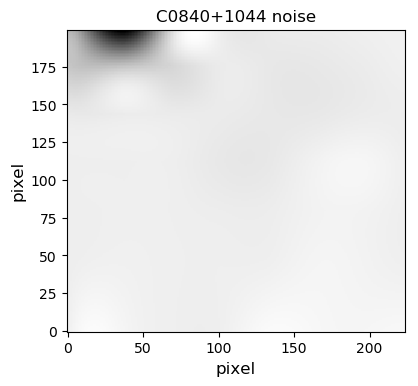

In [315]:
#mapa RMS - weight maps

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' noise')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(map_rms, origin='lower', cmap='gray_r')
print(map_rms) #Matriz mapa de pixel da galáxia
print(len(map_rms))
#plt.savefig(GHII+'_object.png')

[]


/home/JackS/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


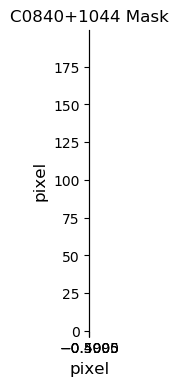

In [316]:
#Fase de TESTE - FLAG derivado do WW, como mask 
#Imagem mask. Estou usando uma matriz 2D 0 e 1
#A mascara é uma matriz booleana que determina os pixels a serem desconsiderados. True é desconsiderado.

Mask = Mask >= 1  #transforma em matriz booleana

fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' Mask')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(Mask, origin='lower',  cmap='gray')
print(Mask)
#plt.savefig(GHII+'_mask.png')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


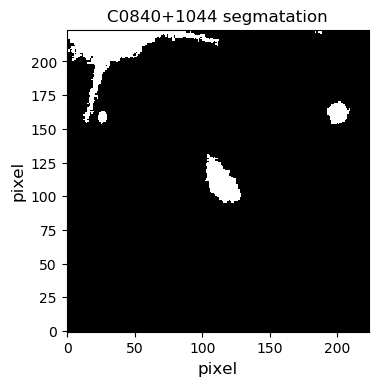

In [317]:
#Segmentação derivada do SEXTRACTOR
segmap = Segmap
segmap= segmap > 0.1
fig = plt.figure(dpi=100, edgecolor='white')
ax = fig.add_subplot(111)
plt.title(filename+' segmatation')
plt.xlabel('pixel',fontsize=12)
plt.ylabel('pixel',fontsize=12)
plt.imshow(segmap, origin='lower', cmap='gray')
print(segmap)

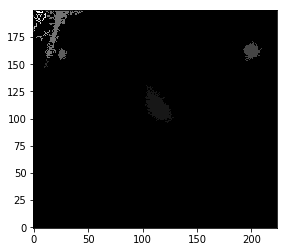

In [323]:
# Segmentação derivada da tarefa PHOTOTUTILS
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
threshold = photutils.detect_threshold(image_data, snr=2.0)
npixels =8  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)
plt.imshow(segm, origin='lower', cmap='gray')

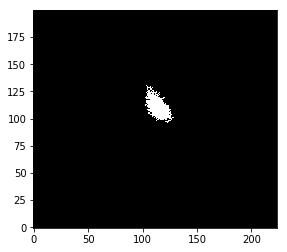

In [324]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

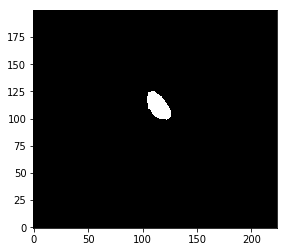

In [325]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

#plt.savefig(GHII+'_segment.png')

In [326]:
#Se tiver fontes sobrepostas usar
#objeto.deblend_sources() #para alterar as fontes.

In [327]:
#Agora que temos todos os dados necessários
#Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
#Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time() #Tempo total do processo
source_morphs = statmorph.source_morphology(image_data, segmap, weightmap=map_rms, psf=psf, niter_bh_mid=100, eta=0.2)
print('Time: %g s.' % (time.time() - start))

Finished processing source 1.

Time: 2.45829 s.


In [328]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('Asymmetry as described in Lotz et al. (2004) =',morph.asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A , asymmetry as described in Lotz et al. (2004) =', morph.asymmetry)
print('S , smoothness as described in Conselice (2003) =', morph.smoothness)
print('Shape asymmetry as described in Pawlik et al. (2016) =', morph.shape_asymmetry)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean, mean background value =', morph.sky_mean)
print('sky_median, median background =', morph.sky_median)
print('sky_sigma, std devia. background =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcsec =',morph.r50*0.396127)
print('rpetro_circ em arcsec =', morph.rpetro_circ*0.396127)
print('rpetro_ellip em arcsec =', morph.rpetro_ellip*0.396127)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz em arcseg =',morph.rhalf_ellip*0.396127)
print('Fluxpetro_c, Return the sum of the pixel values over a circle aperture = ',morph.flux_circ)
print('Fluxpetro_e, Return the sum of the pixel values over a elliptical aperture =',morph.flux_ellip)
print('Intensity statistic as described in Peth et al. (2016) =',morph.intensity)
print('Desviation statistic as described in Peth et al. (2016) =',morph.deviation) 
print('Multimode statistic as described in Freeman et al. (2013) =',morph.multimode)

xc_centroid = 113.62463407671527
yc_centroid = 110.49799419039938
ellipticity_centroid = 0.43922767313654065
elongation_centroid = 1.7832549005997702
orientation_centroid = -0.8391789662923543
xc_asymmetry = 112.7891192098848
yc_asymmetry = 110.75920544621755
ellipticity_asymmetry = 0.438779149075315
elongation_asymmetry = 1.7818297348581555
orientation_asymmetry = -0.8217263733901201
Asymmetry as described in Lotz et al. (2004) = 0.43748320975078236
rpetro_circ = 11.891717505494933
rpetro_ellip = 14.315337378296952
rhalf_circ = 4.935338881591906
rhalf_ellip = 6.369763693225075
r20 = 2.4418573750907333
r50 = 4.8157109162336615
r80 = 9.397099067419324
Gini = 0.5313507972816965
M20 = -1.2363253035002633
F(G, M20) = -0.4730401181299193
S(G, M20) = 0.027188072122342977
sn_per_pixel = 13.616385
C = 2.9263675572151557
A , asymmetry as described in Lotz et al. (2004) = 0.43748320975078236
S , smoothness as described in Conselice (2003) = 0.06132466873212385
Shape asymmetry as described in Paw

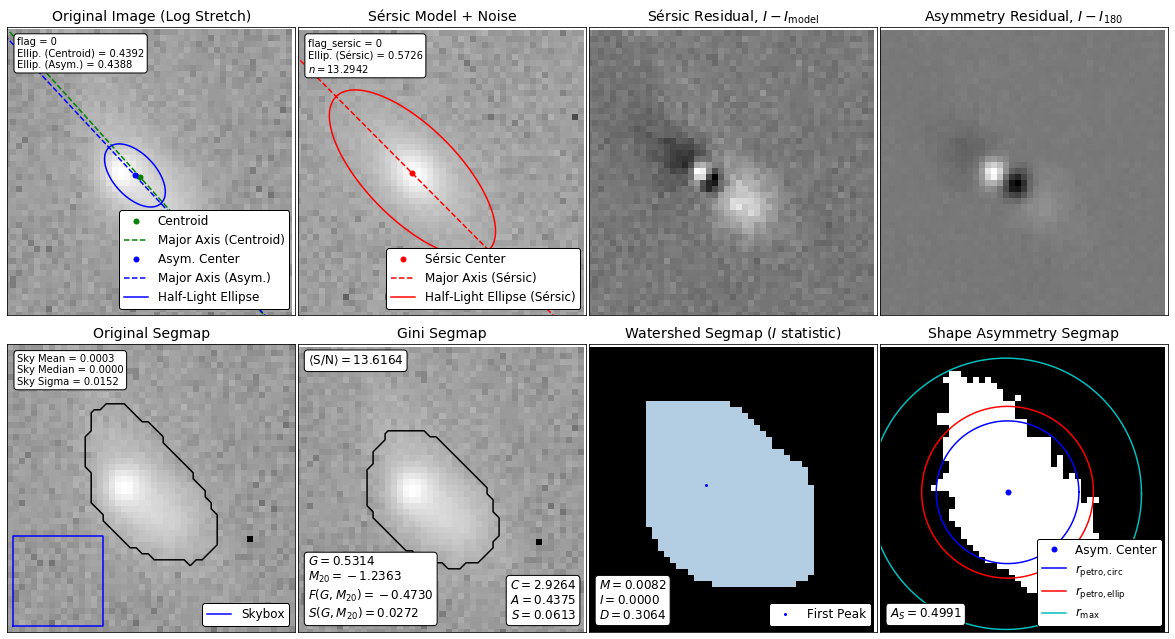

In [329]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig('/run/media/JackS/windocs/SDSS/Imagens/'+filename+'_SDSS_morph.png', dpi=150)

In [330]:
#Tabela de saída csv
from datetime import date
import pandas as pd
date_op = date.today()
date_format = date_op.strftime('%d/%m/%Y')
#date_format ='região menor'

sky_background = morph.sky_sigma
SMA50 = morph.rhalf_ellip
ellip = morph.ellipticity_asymmetry
R50p = morph.r50*0.396127
Rpetro_e = morph.rpetro_ellip*0.396127
Rpetro_c = morph.rpetro_circ*0.396127
fluxpetro_e = morph.flux_ellip

try:
    tabout = pd.read_csv("/home/JackS/Documentos/python/tables/SDSS_tabout_statmorph.csv",encoding = 'UTF-8',sep=";")
    tabout.loc[len(tabout)] = [filename,SMA50,ellip,Rpetro_e,Rpetro_c,R50p,fluxpetro_e,sky_background,date_format]
    tabout.to_csv("/home/JackS/Documentos/python/tables/SDSS_tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")
except FileNotFoundError:
    tabout = pd.DataFrame({'Galaxy':[filename],'SMA_50 (px)':[SMA50],'e':[ellip],'Rpetro_e (arcsec)':[Rpetro_e],
                       'Rpetro_c (arcsec)':[Rpetro_c], 'R_50 (arcsec)':[R50p],'Fluxpetro_e':[fluxpetro_e],'std_dev_Background':[sky_background],
                      'Date':[date_format]},columns = ['Galaxy','SMA_50 (px)','e','Rpetro_e (arcsec)','Rpetro_c (arcsec)',
                                                         'R_50 (arcsec)','Fluxpetro_e','std_dev_Background',
                                                         'Date'])
    tabout.to_csv("/home/JackS/Documentos/python/tables/SDSS_tabout_statmorph.csv",index=False,encoding = 'UTF-8',sep=";")

coment = ' '


In [331]:
CSV = pd.read_csv("/home/JackS/Documentos/python/tables/SDSS_tabout_statmorph.csv",encoding = 'UTF-8',sep=";")
CSV.head(len(tabout))

,Galaxy,SMA_50 (px),e,Rpetro_e (arcsec),Rpetro_c (arcsec),R_50 (arcsec),Fluxpetro_e,std_dev_Background,Date
0,MRK1271,7.578341,0.269295,7.274728,6.191742,2.252394,1076.333114,0.017154,30/04/2020
1,IIZw40,16.648272,0.457644,13.041302,8.720930,2.908337,1034.320567,0.018266,30/04/2020
2,IIZw70,13.841692,0.623098,12.509616,5.990837,2.427103,1476.427147,0.013095,30/04/2020
3,MRK1318,26.847303,0.199192,26.927541,23.887981,9.755459,2179.411539,0.021333,30/04/2020
4,MRK36,11.208521,0.344169,9.369323,7.807044,3.303237,829.588618,0.014814,01/05/2020
5,UM439,17.856896,0.452685,15.608957,11.818943,5.450812,1203.297384,0.016028,01/05/2020
6,UM455,7.611858,0.427898,6.491301,5.474781,2.216630,177.135068,0.015318,01/05/2020
7,UM456,25.237112,0.536950,24.482695,19.123899,7.294476,783.774987,0.015909,01/05/2020
8,UM461,10.233239,0.200724,7.718122,7.112534,3.739957,484.169101,0.017351,01/05/2020
9,UM463,4.102655,0.284682,3.643086,3.254345,1.380476,103.415982,0.018632,01/05/2020
